# 📚Librerias 

In [86]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic


# -------------
import warnings

# Desactivar las advertencias de DeprecationWarning
warnings.filterwarnings("ignore")

# 🔁 Importar funciones personalizadas

In [87]:
%run pandas-missing-extension.ipynb

# 🔁 Importando los datos

In [88]:
%run download_proyect.ipynb

El dataset de tiene 8366 filas y 13 columnas. Para un totla de datos de 108758


# 👀Visualizar valores faltantes

In [89]:
# el .number_missing es una funcion que creamos en otro notebook y trajimos a este notebook
# Nos da el valor total de datos faltantes en el data Frame
print("La cantidad de datos faltantes en el data frame es de: ",nhanes_df.missing.number_missing())

La cantidad de datos faltantes en el data frame es de:  25403


In [90]:
# Datos NaN por columna 
print("Tabla: Cantidad de valores faltantes por columna")
nhanes_df.missing.missing_variable_summary()

Tabla: Cantidad de valores faltantes por columna


,variable,n_missing,n_cases,pct_missing
0,general_health_condition,2402,8366,28.711451
1,age,0,8366,0.000000
2,gender,0,8366,0.000000
3,height,2710,8366,32.393019
4,weight,2642,8366,31.580206
5,diebetes,179,8366,2.139613
6,pulse,1624,8366,19.411905
7,total_cholesterol,1628,8366,19.459718
8,vigorous_work_activity,2839,8366,33.934975
9,moderate_work_activity,2838,8366,33.923022


*La columna que mas datos faltantes contiene es "minutes_sedentary_activity" seguida por "vigorous_work_activity"*

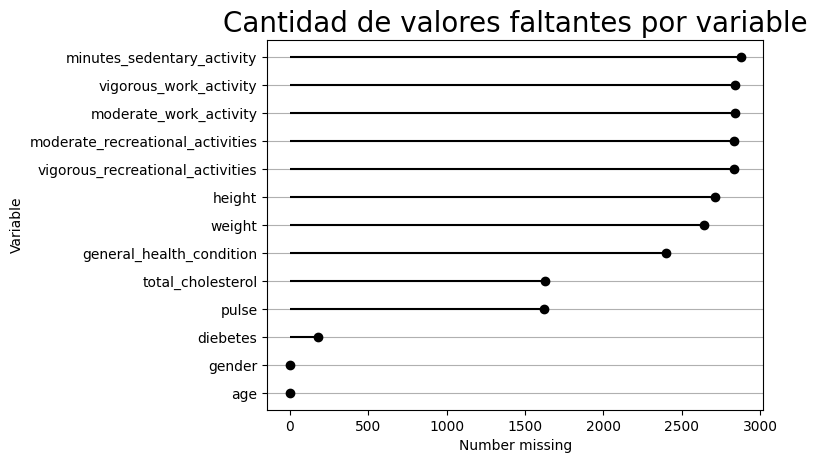

In [91]:
nhanes_df.missing.missing_variable_plot()
plt.title("Cantidad de valores faltantes por variable", fontsize=20);

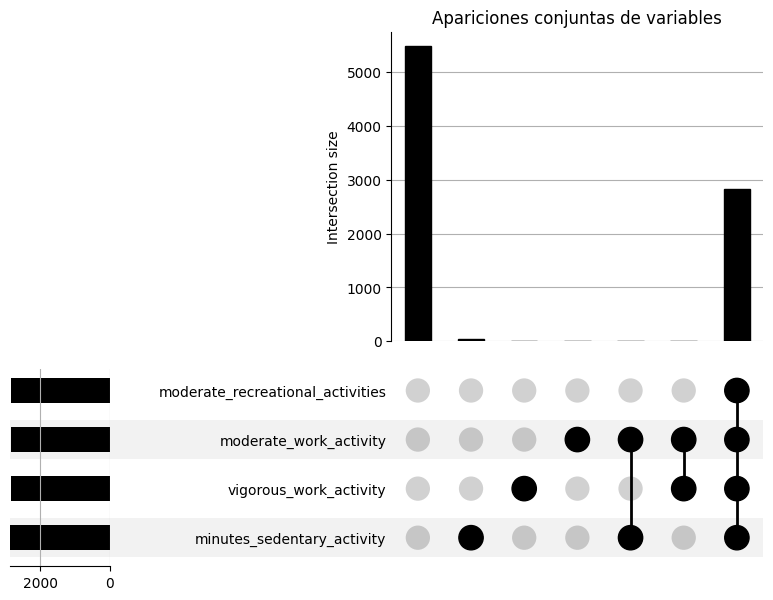

In [92]:
nhanes_df.missing.missing_upsetplot(
    variables= ["minutes_sedentary_activity","vigorous_work_activity","moderate_work_activity","moderate_recreational_activities"], # None -> para tomar todas las variables
    element_size= 50
)
plt.title("Apariciones conjuntas de variables");

*Con esto podemos concluir que los valores NaN de la columna de "minutes_sedentary_activity" comparten valores NaN con las columnas de actividad*

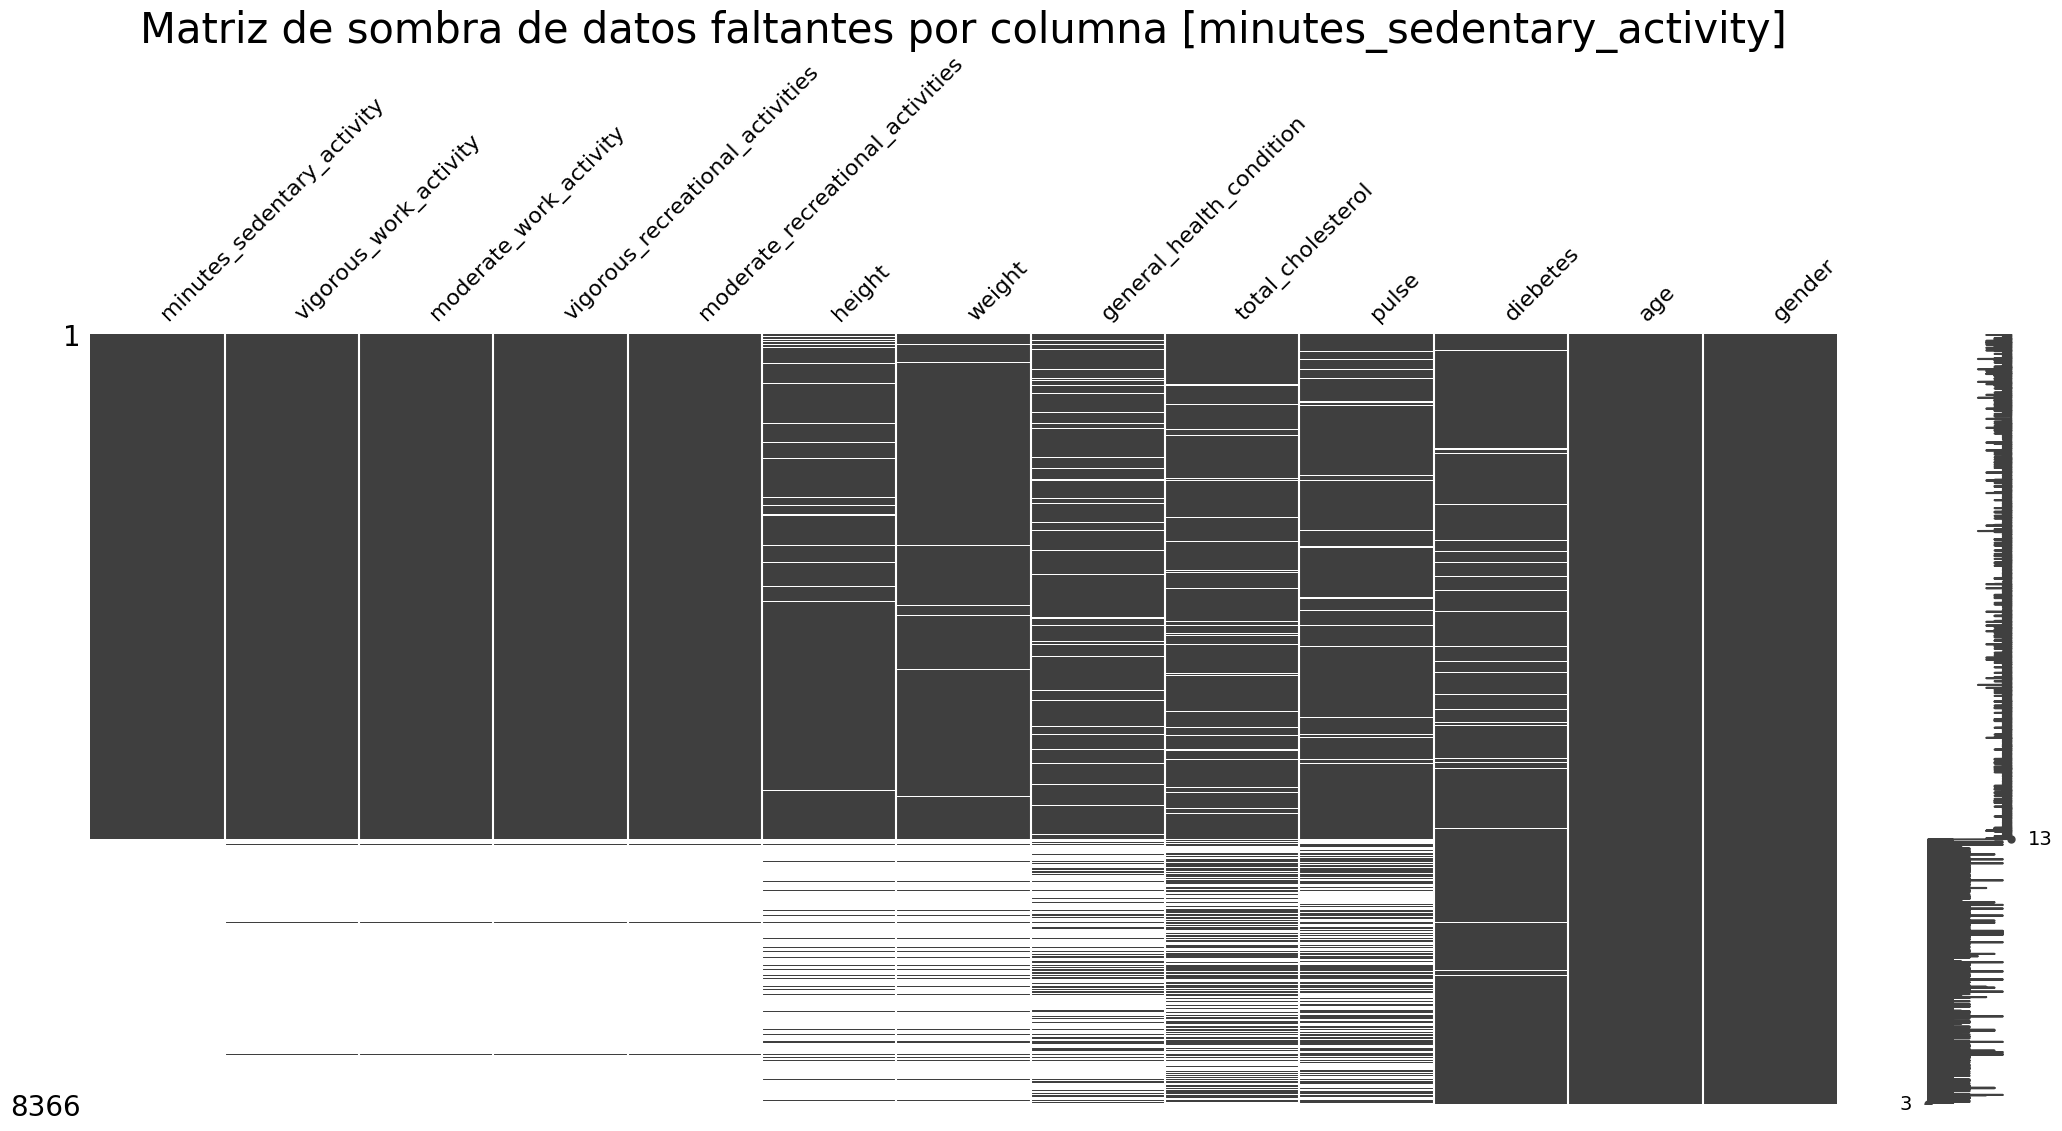

In [93]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .sort_values(by="minutes_sedentary_activity")
    # ordena los valores segun una columna
    .pipe(missingno.matrix)
                

)
plt.title("Matriz de sombra de datos faltantes por columna [minutes_sedentary_activity]", fontsize=30);

*Con esto estamos frente a un caso de MAR (Missing at Random)*

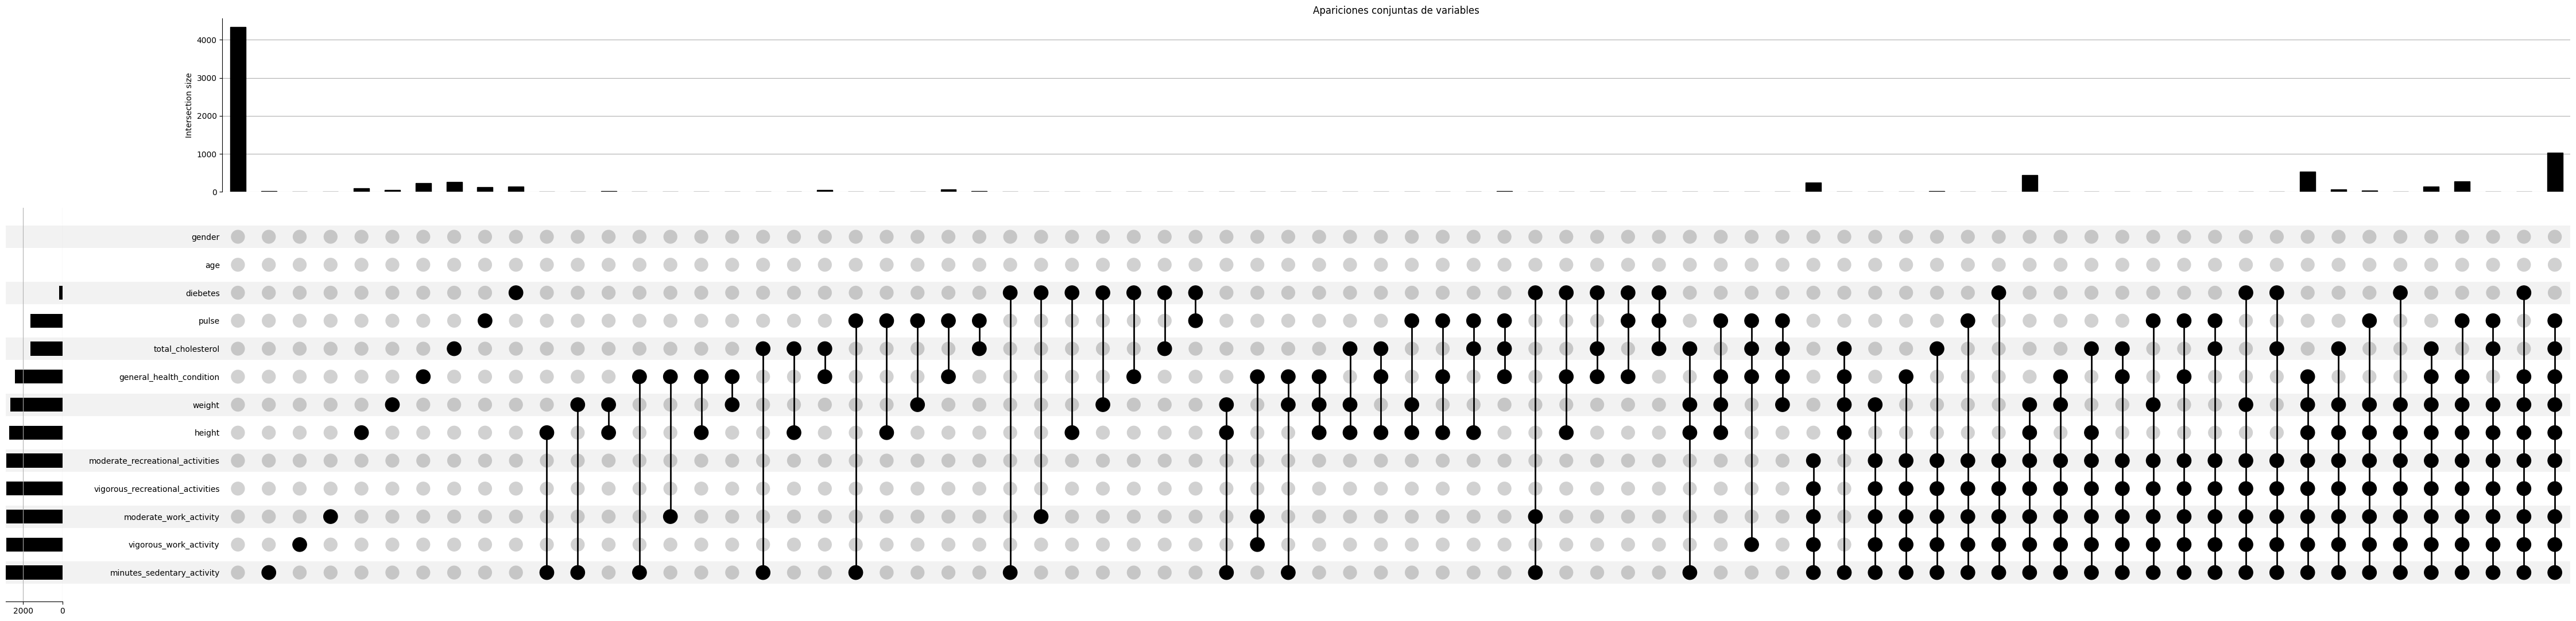

In [94]:
nhanes_df.missing.missing_upsetplot(
    element_size= 50
)
plt.title("Apariciones conjuntas de variables");

In [95]:
# Eliminamos datos que en todas sus filas tiene NaN
nhanes_df = (
    nhanes_df
    .dropna(
        subset = ["minutes_sedentary_activity","vigorous_work_activity","moderate_work_activity","vigorous_recreational_activities","moderate_recreational_activities","pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        # "all" -> Eliminar filas solo si todos los valores son nulos
        how = "all"  # "any" -> Eliminar filas con al menos un valor nulo
    )
    .missing.sort_variables_by_missingness()
    
)
nhanes_df.shape

(7336, 13)

#  Implicaciones de los distintos tipos de valores faltantes

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li><code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.
        </li>
        <li><code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
        <li><code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
    </ul>
    </p>
</div>

In [96]:
# Selecciona las columnas "gender" y "minutes_sedentary_activity" del DataFrame nhanes_df
female_minutes_sedentary_activity, male_minutes_sedentary_activity= (
    nhanes_df
    .select_columns("gender", "minutes_sedentary_activity")
    
    # Transforma la columna "minutes_sedentary_activity" usando una función lambda que devuelve True si el valor es nulo
    .transform_column(
        "minutes_sedentary_activity",
        lambda x: x.isnull(),
        elementwise=False # Se aplica a toda la columna en lugar de elemento por elemento
    )
    
    # Agrupa el DataFrame resultante por la columna "gender"
    .groupby("gender")
    
    # Accede a la columna "weiminutes_sedentary_activityght" del grupo correspondiente a "Female" y "Male"
    .minutes_sedentary_activity
    
    # Utiliza la función pipe para aplicar una función lambda que devuelve dos grupos separados
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

# Realiza una prueba estadística de la diferencia de medias entre female_weight y male_weight
scipy.stats.ttest_ind(
    a=female_minutes_sedentary_activity,
    b=male_minutes_sedentary_activity,
    alternative="two-sided"
)


TtestResult(statistic=-1.2051426883194678, pvalue=0.2281871065386976, df=7334.0)

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Interpretación</b>
    <br>
    <br>
    <p>
    <ul>
        <li>La estadística t (-1.205) nos indica la dirección y la magnitud de la diferencia entre las dos muestras. En este caso, el valor es negativo, lo que sugiere que la media de female_minutes_sedentary_activity podría ser menor que la de male_minutes_sedentary_activity.
        </li>
        <li>El valor p (0.228) es mayor que el nivel de significancia comúnmente utilizado (como 0.05), lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula de que las dos muestras tienen la misma media..
        </li>
        <li>Por lo tanto, no hay suficiente evidencia para concluir que hay una diferencia significativa entre la actividad sedentaria de mujeres y hombres en la población representada por estas muestras.
        </li>
    </ul>
    </p>
</div>

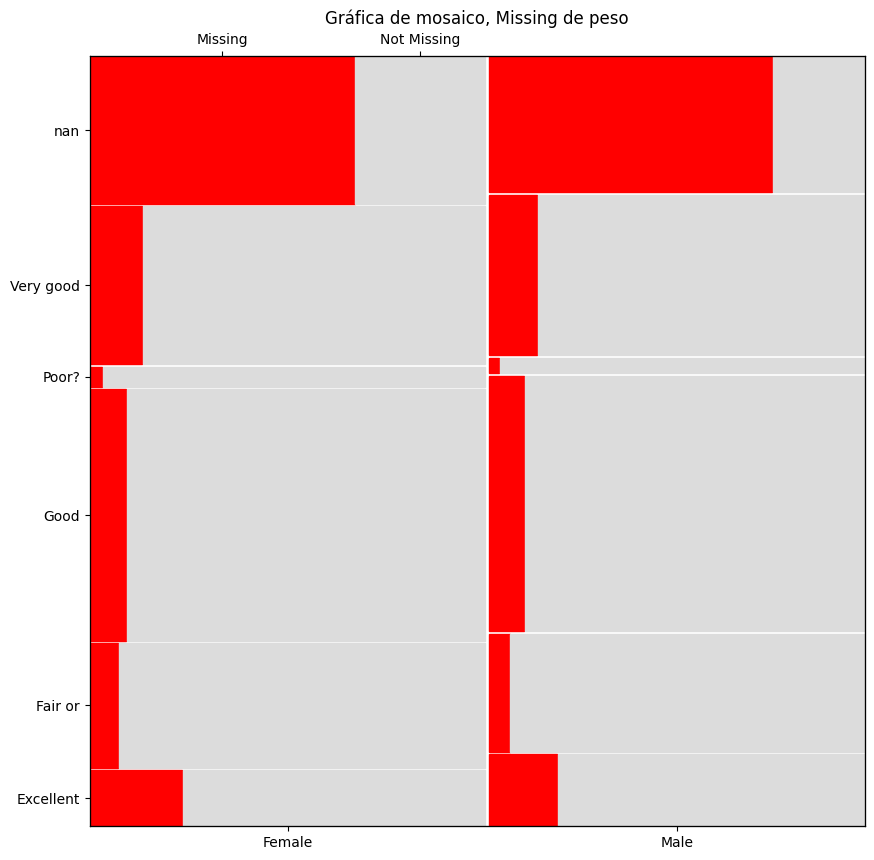

In [97]:
fig, ax = plt.subplots(figsize = (10,10))
(
    nhanes_df
    .select_columns("weight", "general_health_condition","gender")
    .assign(
        weight = lambda df : df.weight.isna().replace([True, False], ["Missing", "Not Missing"])
    )
    .groupby(
        ["gender", "general_health_condition","weight"],
        dropna = False, # no elimine valores faltantes
        as_index = True
    )
    .size()
    .pipe( 
        lambda df: mosaic(
            data = df,
            properties = lambda key : {"color": "r" if  "Missing" in key else "#dcdcdc"},
            horizontal = True,
            axes_label = True,
            title  = "Gráfica de mosaico, Missing de peso",
            labelizer  = lambda key: "",
            ax = ax
        )
    )
);

# Tratamiento de variables categóricas para imputación: codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li>Una codificación ordinal implica mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
        </li>
    </ul>
    </p>
</div>

In [98]:
nhanes_transformed_df = nhanes_df.copy(deep= True) # deep =True - > Se copian tanto los datos como los índices, cualquier objeto contenido dentro del DataFrame

In [99]:
# Extraemos todas las columnas categoricas del DataFrame
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns
categorical_columns

Index(['general_health_condition', 'diebetes', 'gender'], dtype='object')

In [100]:
# funcion de skylearn para transforman datos

categorical_transformer  = sklearn.compose.make_column_transformer( # 
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    # Cualquier columna no mencionada en las transformaciones anteriores se mantendrá sin cambios y se incluirá en el conjunto de datos.
     remainder="passthrough"
)




In [101]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index #Traemos los index del dataframe original
    )
    .rename_columns(
        function = lambda x : x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x : x.removeprefix("remainder__")
    )

)

In [102]:
nhanes_transformed_df

,general_health_condition,diebetes,gender,minutes_sedentary_activity,vigorous_work_activity,moderate_work_activity,vigorous_recreational_activities,moderate_recreational_activities,height,weight,total_cholesterol,pulse,age
SEQN,,,,,,,,,,,,,
93705.0,2.0,0.0,0.0,300.0,0.0,0.0,0.0,1.0,63.0,165.0,157.0,52.0,66.0
93706.0,4.0,0.0,1.0,240.0,0.0,0.0,0.0,1.0,68.0,145.0,148.0,82.0,18.0
93707.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0,100.0,13.0
93708.0,2.0,NaN,0.0,120.0,0.0,0.0,0.0,1.0,60.0,118.0,209.0,68.0,66.0
93709.0,NaN,0.0,0.0,600.0,0.0,1.0,0.0,0.0,62.0,200.0,176.0,74.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,4.0,NaN,0.0,120.0,0.0,0.0,0.0,1.0,NaN,117.0,119.0,68.0,70.0
102953.0,1.0,0.0,1.0,360.0,1.0,1.0,0.0,0.0,65.0,218.0,182.0,78.0,42.0
102954.0,2.0,0.0,0.0,600.0,0.0,0.0,0.0,1.0,66.0,150.0,172.0,78.0,41.0


# Imputación basada en donante

## Imputación de unico valor (Media, mediana, moda)

| Método de Imputación | Ventajas                                             | Desventajas                                          |
|-----------------------|------------------------------------------------------|------------------------------------------------------|
| Imputación por Media  | - Preserva la media global.                         | - Sensible a valores atípicos.                       |
|                       | - Apropiado para datos normalmente distribuidos.    | - Puede distorsionar la distribución si los datos no son normales. |
| Imputación por Mediana| - Robusta frente a valores atípicos.                | - No preserva la media global.                       |
|                       | - Apropiado para datos no normales.                 |                                                      |
| Imputación por Moda   | - Simple y rápido.                                  | - No es adecuado para variables continuas.          |
|                       | - Apropiado para datos categóricos.                 | - No aborda la variabilidad de los datos.            |


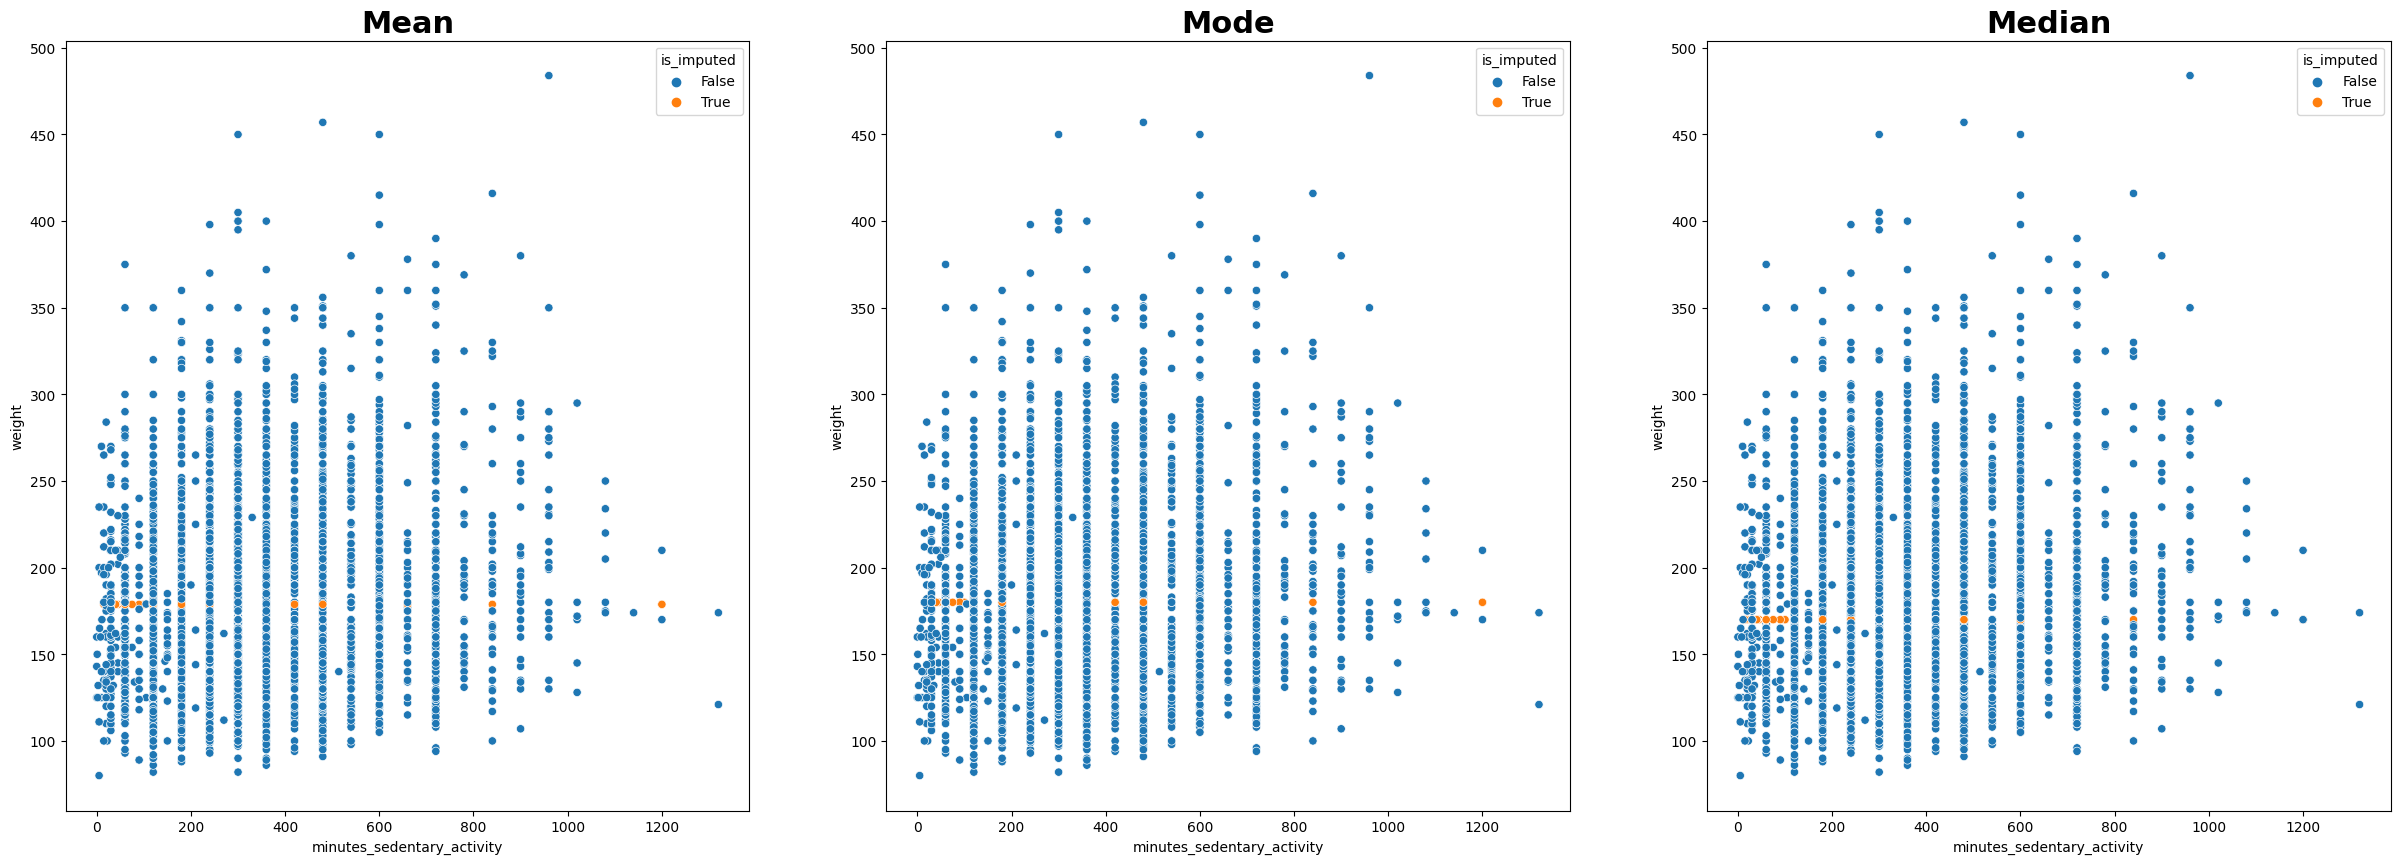

In [103]:
fig, ax = plt.subplots(1,3,figsize=(30,10),sharey=False)



# con la media
(
    nhanes_df
    .select_columns("minutes_sedentary_activity", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.minutes_sedentary_activity.fillna(value = df.minutes_sedentary_activity.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x="minutes_sedentary_activity", 
        y="weight", 
        #show_marginal=True, 
        #height=10,
        ax = ax[0]
        )
);

# Con la moda
(

    nhanes_df
    .select_columns("minutes_sedentary_activity", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.minutes_sedentary_activity.fillna(value = df.minutes_sedentary_activity.mode()[0]),
        weight = lambda df: df.weight.fillna(value = df.weight.mode()[0])
    )
    .missing.scatter_imputation_plot(
        x="minutes_sedentary_activity", 
        y="weight", 
        #show_marginal=True, 
        #height=10,
        ax = ax[1]
        )
);

# Calcularlo con la mediana 
(

    nhanes_df
    .select_columns("minutes_sedentary_activity", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.minutes_sedentary_activity.fillna(value = df.minutes_sedentary_activity.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    )
    .missing.scatter_imputation_plot(
        x="minutes_sedentary_activity", 
        y="weight", 
        #show_marginal=True, 
        #height=10,
        ax = ax[2]
        )
);

ax[0].set_title("Mean", fontsize =22, fontweight='bold');
ax[2].set_title("Median", fontsize =22, fontweight='bold');
ax[1].set_title("Mode", fontsize =22, fontweight='bold');



## Imputación por llenado hacia atrás y hacia adelante

*Imputación por Llenado Hacia Atrás y Hacia Adelante (Hot Deck y Cold Deck)*

La imputación por llenado hacia atrás y hacia adelante consiste en sustituir los valores faltantes con valores completos que están antes o después en la secuencia de datos.

*Ventajas*

- **Rápido y fácil de implementar**
- Los datos imputados no son constantes, dependen de los valores alrededor (arriba, abajo, a la derecha o a la izquierda).
- Existen trucos para evitar romper las relaciones entre variables.

*Desventajas*

- Las relaciones multivariables pueden ser distorsionadas


### fillna() vs ffill() o bfill()

Muy útil la recomendación a la hora de hacer la imputación hacia adelante organizar por datos o grupos similares, de esta manera los datos reemplazados se parecen a sus semejantes.

In [104]:
(
    nhanes_df
    .select_columns("gender","height","weight","diebetes","general_health_condition","minutes_sedentary_activity")
    .sort_values(
        by = ["gender","diebetes","general_health_condition","minutes_sedentary_activity","weight"],
        ascending= True
    )
    .transform_column(
        "minutes_sedentary_activity",
        lambda x : x.ffill(),
        elementwise = False
    )
    
)

,gender,height,weight,diebetes,general_health_condition,minutes_sedentary_activity
SEQN,,,,,,
94148.0,Female,65.0,100.0,0,Excellent,22.0
100748.0,Female,67.0,140.0,0,Excellent,30.0
94421.0,Female,56.0,115.0,0,Excellent,60.0
98065.0,Female,63.0,115.0,0,Excellent,60.0
99879.0,Female,62.0,120.0,0,Excellent,60.0
...,...,...,...,...,...,...
95515.0,Male,75.0,270.0,NaN,Very good,960.0
98759.0,Male,62.0,133.0,NaN,NaN,120.0
98085.0,Male,66.0,189.0,NaN,NaN,180.0


## Imputación por interpolación

In [105]:
nhanes_df

,minutes_sedentary_activity,vigorous_work_activity,moderate_work_activity,vigorous_recreational_activities,moderate_recreational_activities,height,weight,general_health_condition,total_cholesterol,pulse,diebetes,age,gender
SEQN,,,,,,,,,,,,,
93705.0,300.0,0.0,0.0,0.0,1.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,240.0,0.0,0.0,0.0,1.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93708.0,120.0,0.0,0.0,0.0,1.0,60.0,118.0,Good,209.0,68.0,NaN,66.0,Female
93709.0,600.0,0.0,1.0,0.0,0.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,120.0,0.0,0.0,0.0,1.0,NaN,117.0,Very good,119.0,68.0,NaN,70.0,Female
102953.0,360.0,1.0,1.0,0.0,0.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,600.0,0.0,0.0,0.0,1.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


<Axes: xlabel='SEQN'>

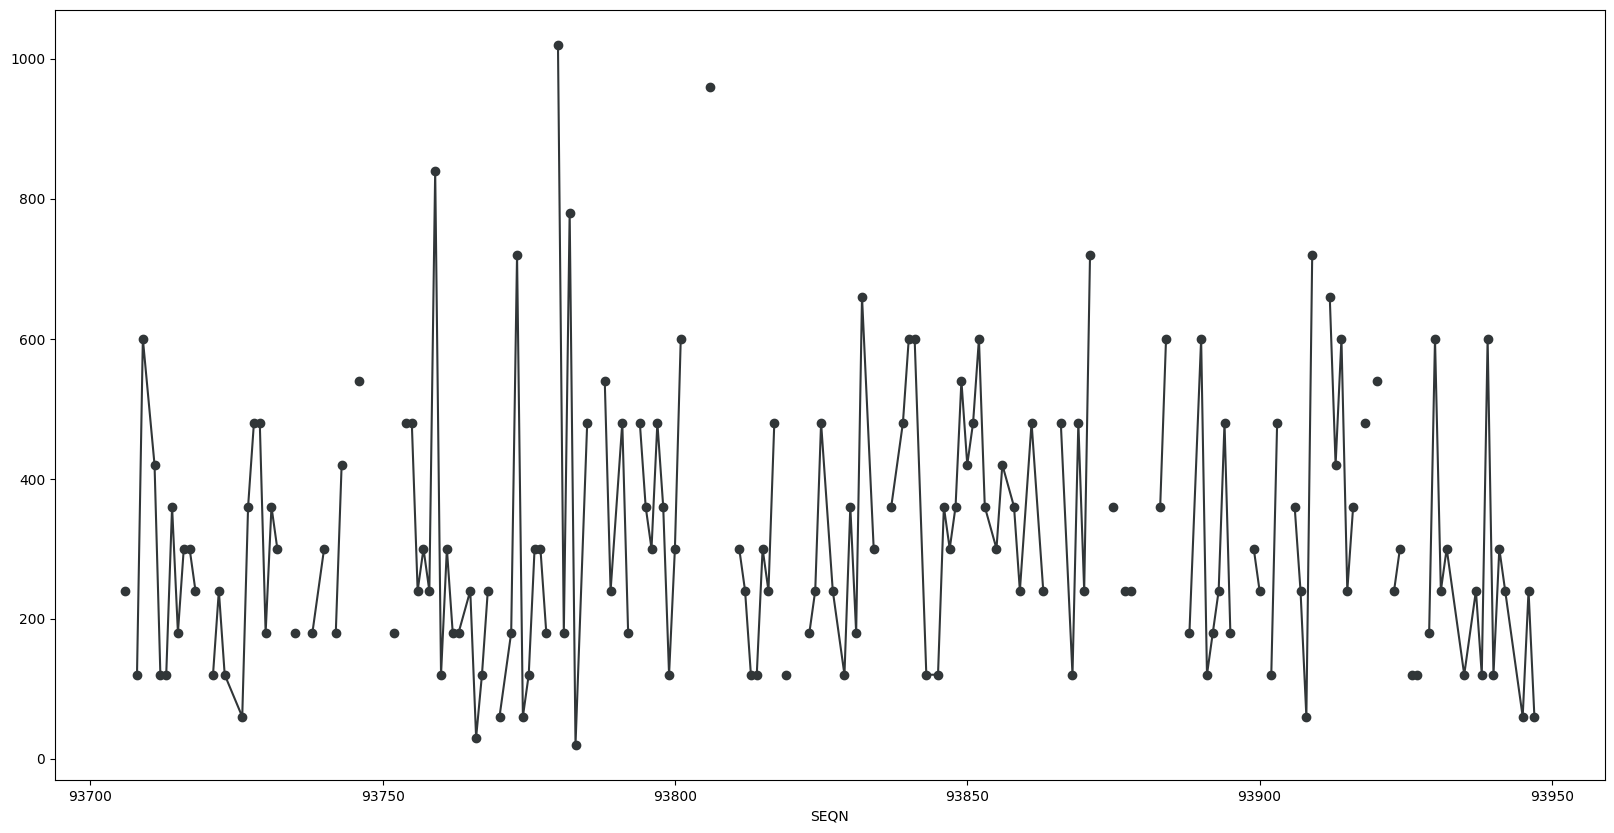

In [106]:
plt.figure(figsize=(20,10))
(
    nhanes_df.select_columns("minutes_sedentary_activity")
    .pipe(
    lambda df: (
        df.minutes_sedentary_activity.iloc[1:200].plot(color = "#313638", marker = "o")
    )   

)
)

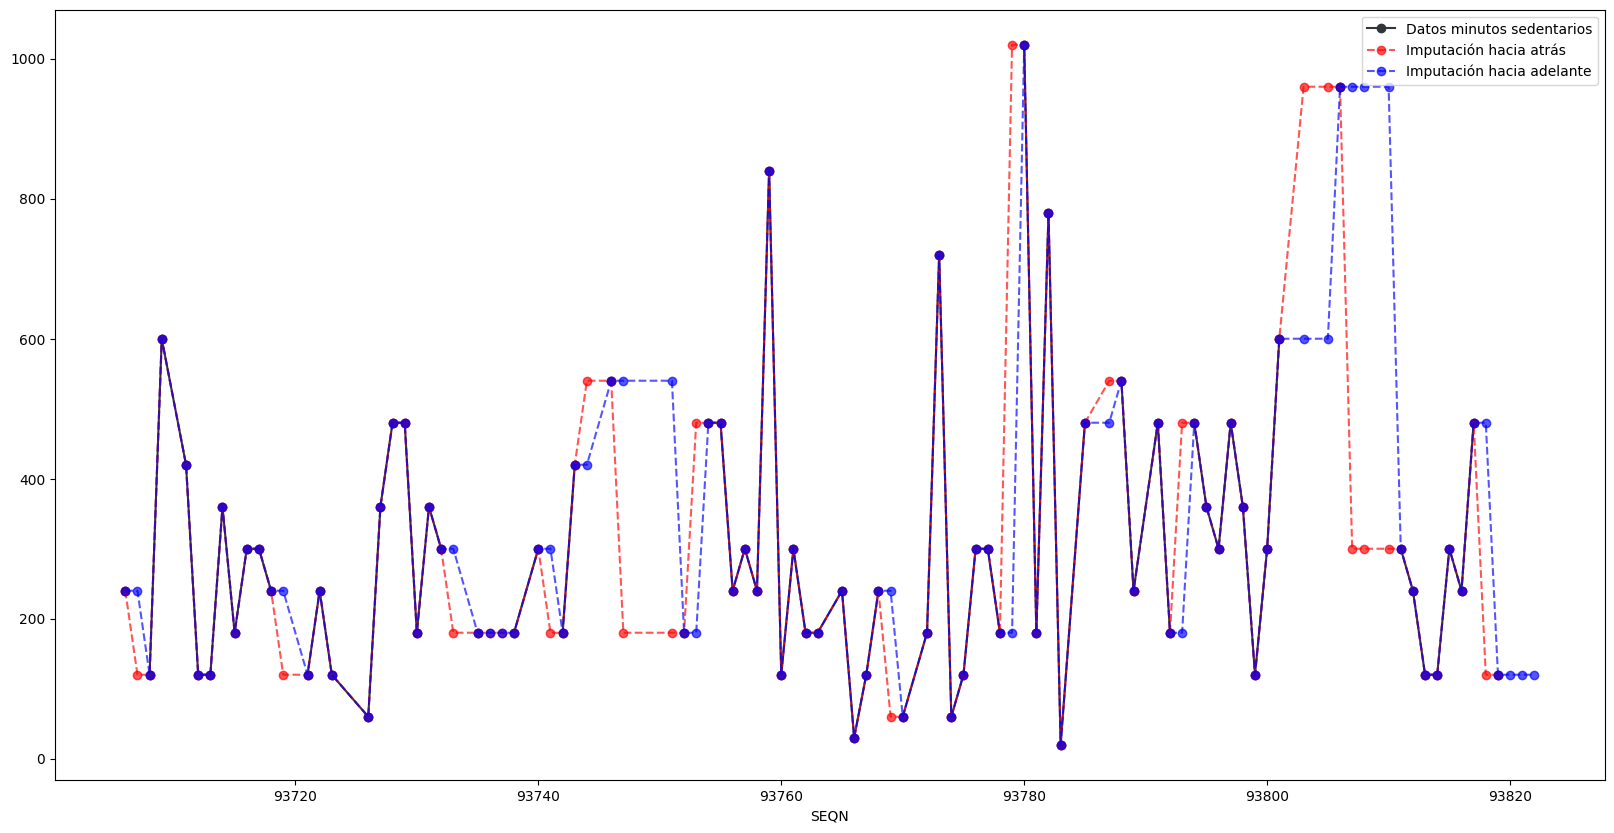

In [107]:
plt.figure(figsize=(20,10))
(
    nhanes_df.select_columns("minutes_sedentary_activity")
    .pipe(
    lambda df: (
        df.minutes_sedentary_activity.iloc[1:100].plot(color = "#313638", marker = "o", label="Datos minutos sedentarios"),
        df.minutes_sedentary_activity.iloc[1:100].bfill().plot(color = "red", marker = "o",alpha=6/9, linestyle = "dashed", label="Imputación hacia atrás"),
        df.minutes_sedentary_activity.iloc[1:100].ffill().plot(color = "blue", marker = "o",alpha=6/9, linestyle = "dashed", label="Imputación hacia adelante")
    )   

)
)
plt.legend();

Esta seria una forma grafica de ver como es la imputación de datos "hacia adelante y hacia atrás", ahora veremos como se comporta con una imputación por interpolación

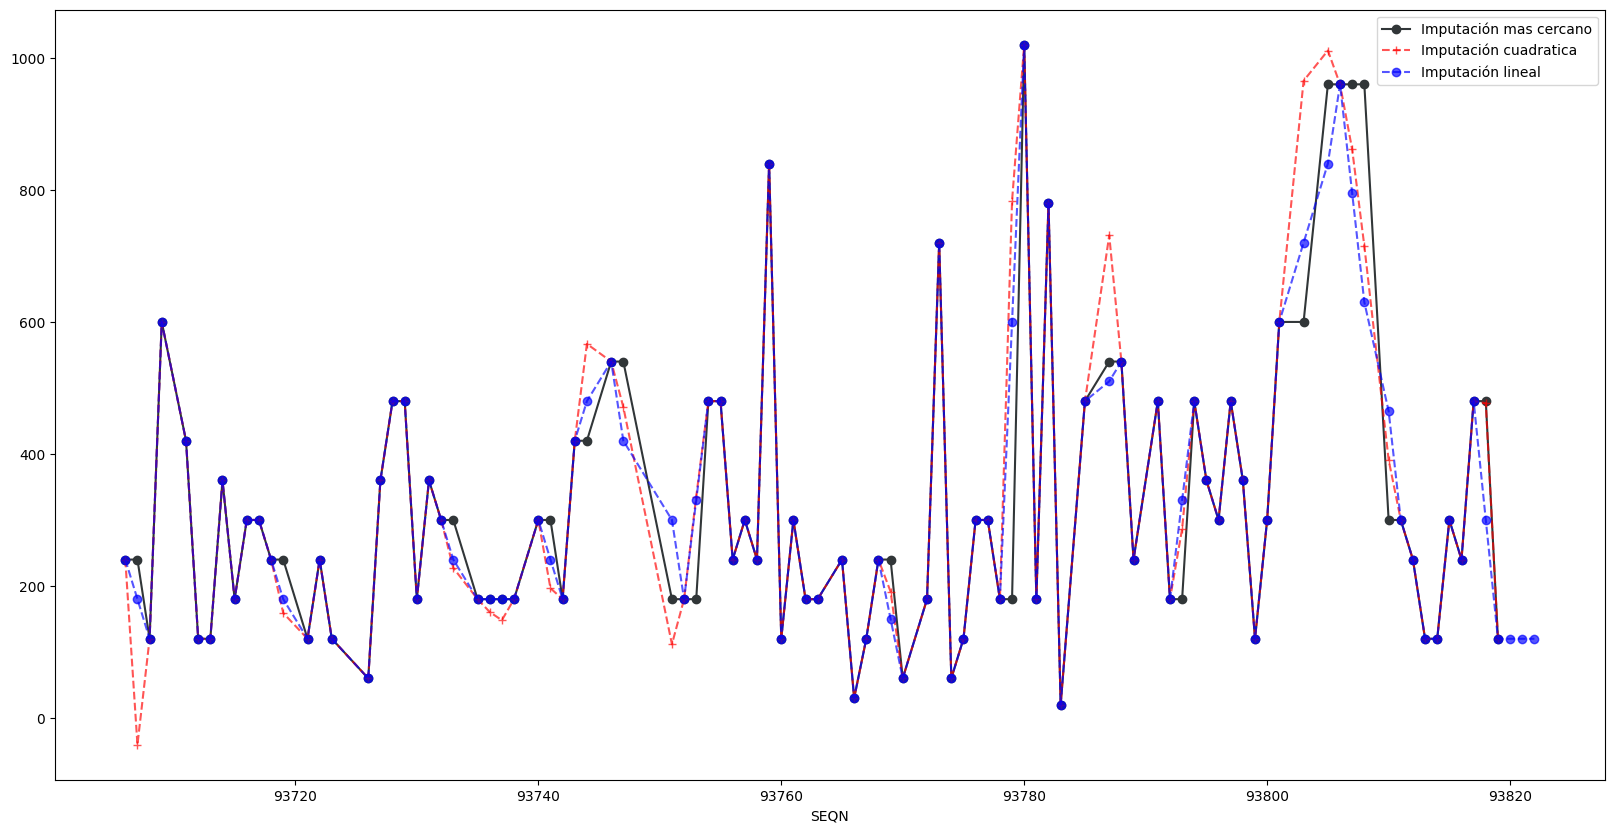

In [108]:
plt.figure(figsize=(20,10))
(
    nhanes_df.select_columns("minutes_sedentary_activity")
    .pipe(
    lambda df: (
        df.minutes_sedentary_activity.iloc[1:100].interpolate(method = "nearest").plot(color = "#313638", marker = "o", label="Imputación mas cercano"),
        df.minutes_sedentary_activity.iloc[1:100].interpolate(method = "quadratic").plot(color = "red", marker = "+",alpha=6/9, linestyle = "dashed", label="Imputación cuadratica"),
        df.minutes_sedentary_activity.iloc[1:100].interpolate(method = "linear").plot(color = "blue", marker = "o",alpha=6/9, linestyle = "dashed", label="Imputación lineal")
    )   

)
)
plt.legend();

La imputación cuadratica, nos muestra unos picos iniciales que estan por debajo de 0, algo que no tiene logica, por tal motivo la descartamos.
La grafica que mas se ajusta a los datos es la imputación lineal. Genera una linea recta entre dos puntos conocidos para establecer los puntos que son desconocidos. 


## Imputación por KNN

*Pasos para imputación por k-Nearest-Neighbors*

1. **Para cada observación con valores faltantes:**
    - Encuentra otras K observaciones (donadores, vecinos) que sean más similares a esa observación.
    - Reemplaza los valores faltantes con los valores agregados de los K vecinos.

2. **¿Cómo determinar cuáles son los vecinos más similares?**
    - **Cuantificación de distancia:** Distancia euclidiana útil para variables numéricas.
    - **Distancia Manhattan:** Útil para variables tipo factor.
    - **Distancia de Hamming:** Útil para variables categóricas.
    - **Distancia de Gower:** Útil para conjuntos de datos con variables mixtas.


### Métricas de Distancia para Determinar Vecinos Similares

### Distancia Euclidiana
- Útil para variables numéricas.
- Se traza una línea recta entre dos puntos en un espacio euclidiano.
- La distancia euclidiana se utiliza como parámetro para definir proximidad.



### Distancia Manhattan
- Muy útil para variables de tipo factor (días de la semana, condiciones como lento, rápido).
- Representa la distancia absoluta entre dos puntos.
  


### Distancia de Hamming
- Útil para variables categóricas.
- Cuantifica la diferencia entre textos.



### Distancia de Gower
- Útil para conjuntos de datos con variables mixtas.
- Se define como la distancia de un vecino a otros vecinos para determinar la distancia global referente a la fila que contiene el valor faltante.



### Ventajas
- Sencillo de implementar.
- Buen rendimiento con conjuntos de datos pequeños.
- Excelente para datos numéricos, pero también funciona para datos mixtos.

### Desventajas
- Su escalabilidad puede ser comprometedora dependiendo del número de variables y el tamaño de las observaciones.
- Requiere transformaciones especiales para las variables categóricas, ya que no solo se introducen números y se necesita cuantificar estas distancias.
- Sensibilidad a valores atípicos.


In [109]:
nhanes_transformed_df

,general_health_condition,diebetes,gender,minutes_sedentary_activity,vigorous_work_activity,moderate_work_activity,vigorous_recreational_activities,moderate_recreational_activities,height,weight,total_cholesterol,pulse,age
SEQN,,,,,,,,,,,,,
93705.0,2.0,0.0,0.0,300.0,0.0,0.0,0.0,1.0,63.0,165.0,157.0,52.0,66.0
93706.0,4.0,0.0,1.0,240.0,0.0,0.0,0.0,1.0,68.0,145.0,148.0,82.0,18.0
93707.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0,100.0,13.0
93708.0,2.0,NaN,0.0,120.0,0.0,0.0,0.0,1.0,60.0,118.0,209.0,68.0,66.0
93709.0,NaN,0.0,0.0,600.0,0.0,1.0,0.0,0.0,62.0,200.0,176.0,74.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,4.0,NaN,0.0,120.0,0.0,0.0,0.0,1.0,NaN,117.0,119.0,68.0,70.0
102953.0,1.0,0.0,1.0,360.0,1.0,1.0,0.0,0.0,65.0,218.0,182.0,78.0,42.0
102954.0,2.0,0.0,0.0,600.0,0.0,0.0,0.0,1.0,66.0,150.0,172.0,78.0,41.0


In [110]:
# Importar la clase KNNImputer de la biblioteca sklearn.impute
import sklearn.impute

# Crear una instancia del imputador KNN (K-Nearest Neighbors)
knn_imputer = sklearn.impute.KNNImputer()

# Crear una copia profunda del DataFrame original nhanes_transformed_df
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

# Utilizar el imputador KNN para rellenar los valores faltantes en el DataFrame copiado
# fit_transform() ajusta el modelo a los datos y transforma el DataFrame
# round() redondea los valores resultantes a números enteros
nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_transformed_df).round()

# Mostrar el DataFrame resultante con los valores imputados
nhanes_df_knn

,general_health_condition,diebetes,gender,minutes_sedentary_activity,vigorous_work_activity,moderate_work_activity,vigorous_recreational_activities,moderate_recreational_activities,height,weight,total_cholesterol,pulse,age
SEQN,,,,,,,,,,,,,
93705.0,2.0,0.0,0.0,300.0,0.0,0.0,0.0,1.0,63.0,165.0,157.0,52.0,66.0
93706.0,4.0,0.0,1.0,240.0,0.0,0.0,0.0,1.0,68.0,145.0,148.0,82.0,18.0
93707.0,2.0,0.0,1.0,276.0,0.0,1.0,0.0,0.0,69.0,130.0,189.0,100.0,13.0
93708.0,2.0,0.0,0.0,120.0,0.0,0.0,0.0,1.0,60.0,118.0,209.0,68.0,66.0
93709.0,3.0,0.0,0.0,600.0,0.0,1.0,0.0,0.0,62.0,200.0,176.0,74.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,4.0,0.0,0.0,120.0,0.0,0.0,0.0,1.0,63.0,117.0,119.0,68.0,70.0
102953.0,1.0,0.0,1.0,360.0,1.0,1.0,0.0,0.0,65.0,218.0,182.0,78.0,42.0
102954.0,2.0,0.0,0.0,600.0,0.0,0.0,0.0,1.0,66.0,150.0,172.0,78.0,41.0


<Axes: xlabel='minutes_sedentary_activity', ylabel='weight'>

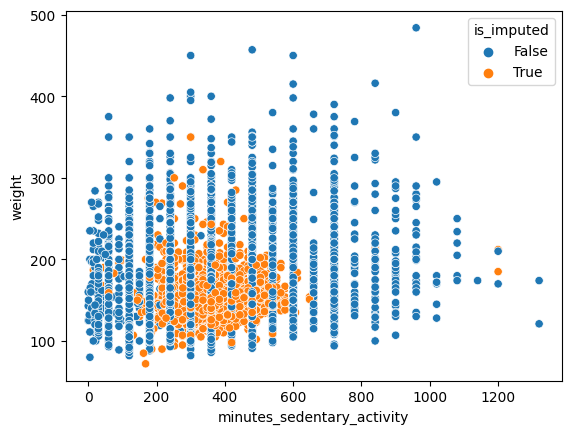

In [111]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x="minutes_sedentary_activity", 
        y="weight")
)

### Ordenamiento por cantidad de variables faltantes

<Axes: xlabel='minutes_sedentary_activity', ylabel='weight'>

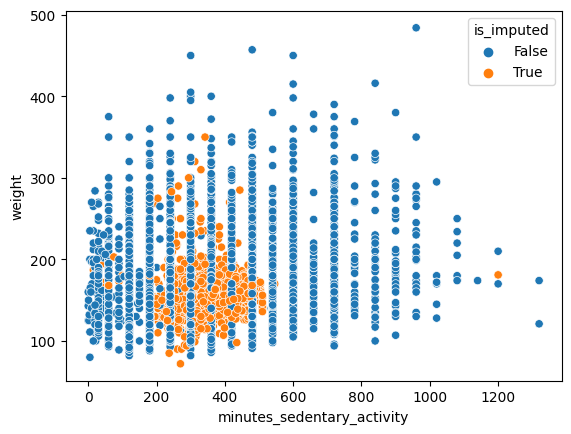

In [112]:
# Crear una instancia del imputador KNN con 10 vecinos más cercanos
knn_imputer = sklearn.impute.KNNImputer(n_neighbors=10)

# Ordenar las variables del DataFrame original por la cantidad de valores faltantes en orden ascendente
# Esto se hace utilizando el método missing.sort_variables_by_missingness(ascending=True)
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

# Utilizar el imputador KNN para rellenar los valores faltantes en el DataFrame copiado
# fit_transform() ajusta el modelo a los datos y transforma el DataFrame
# round() redondea los valores resultantes a números enteros
nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()

(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="minutes_sedentary_activity", y="weight")
)

# Imputación Basada en modelos

Cuando se utiliza un modelo para imputar, en principio no aceptan valores faltantes por lo que el primer paso es imputar los valores faltantes con dummies. Luego se utiliza el modelo y se va iterando hasta que los valores que hemos sustituido con dummies no cambien. Justo alli se llega a una optima imputacion.

In [124]:
# preparamos los datos de la variable a imputar

nhanes_model_df= (
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'age')    # seleccionamos columnas
    .sort_values(by='height')   # ordenamos en funcion de height
    #   sustituir los valores faltantes con dummies 
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
      #   matriz de sombra con el sufijo imp
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix='_imp',

    )
)
#interpolate(method = "linear")

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False
102945.0,NaN,107.0,Male,15.0,True,False,False,False


In [125]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age ",  data=df)
    )
    .fit()
 
)


In [127]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102926.0    63.0
102941.0    63.0
102945.0    68.0
102952.0    62.0
102955.0    63.0
Length: 1680, dtype: float64

In [128]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False
102945.0,68.0,107.0,Male,15.0,True,False,False,False
